# Abstract
This paper demonstrates statistical analysis performed in Python on a dataset containing growth performance of 3 hair treatment brands, plus a Placebo.

The analysis showed that age did not have an effect on hair growth, and that Luxuriant performed significantly well against the Placebo, with an average growth of 13.0mm. However, it was was outperformed by the established brands HairyGoodness and BaldBeGone.

Still, Luxuriant's performance over the Placebo by 10.51mm indicates that it can be released to market, although future trials should separate placebo testing and existing treatment testing.

# Introduction

Analysis was conducted on hair growth and age data for four hair treatments: Luxuriant, a new product; HairyGoodness and BaldBeGone, both established brands; and a Placebo. The means and 95% confidence intervals were computed, and ANOVA and Ordinary Least Squares modeling performed to answer the questions:

1. Is there an effect of Luxuriant above and beyond the placebo? 
2. Is Luxuriant more effective than the existing treatments on the market? 
3. Is age relevant to any effect?

The results show that Luxuriant works significantly better than the Placebo, with an average growth of 13.0mm versus 2.49mm. However, HairyGoodness and BaldBeGone outperformed Luxuriant with averages of 36.15mm and 18.74mm respectively. Age was not found to have a significant effect.

# Methods

A dataset containing 100 rows of hair growth data was prepared in Python. Growth was converted from inches to millimeters (via `pandas.apply()` and a lambda function `x: x*25.4`), and age rounded off with `.round()`, and casted `.astype(int)`. This preliminary dataset (@tbl-converted-figures) was used for ANOVA and t-tests.

In [1]:
# Load the required libraries and set the color palette for the graphs
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import seaborn as sns
from scipy.stats import shapiro
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.gofplots import qqplot

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="colorblind")

In [2]:
# PART 0 - DATA WRANGLING

In [3]:
# Load the unformatted dataset
df = pd.read_csv(r"data/HairGrowth.csv")

# Uncomment to view the head
# df.head(5)

In [4]:
# Convert hair growth from inches to millimeter by applying a lambda function to multiply those column values by 25.4
df[["Luxuriant", "Placebo", "BaldBeGone", "HairyGoodness"]] = \
    df[["Luxuriant", "Placebo", "BaldBeGone", "HairyGoodness"]].apply(lambda x: x * 25.4)

In [5]:
# Round off the ages to whole years, and cast the values to type integer
df[["AgeLuxuriant", "AgePlacebo", "AgeBaldBeGone", "AgeHairyGoodness"]] = \
    df[["AgeLuxuriant", "AgePlacebo", "AgeBaldBeGone", "AgeHairyGoodness"]].round().astype(int)
df_head = df.head(5)

# See appendix for the rendered table

This was further tidied to have one row per participant with columns "Brand", "Growth" and "Age". Temporary datasets were created for each brand, then appended together with `pd.concat()`. The full dataset previewed in @tbl-tidy-dataframe has 400 rows and 3 columns, and was used for visualisations and OLS linear modeling.

In [6]:
# Create a series of dataframes with columns "Brand", "Growth", "Age"
# These dataframes will be merged later on and used for easier visualisations

# LUXURIANT BRAND
df_Luxuriant = df[["Luxuriant", "AgeLuxuriant"]]

# Rename the columns
df_Luxuriant = df_Luxuriant.rename(columns={"Luxuriant": "Growth",
                                            "AgeLuxuriant": "Age"})

# Add a new column for Brand set to 'Luxuriant'
df_Luxuriant.insert(0, "Brand", "Luxuriant")

In [7]:
# Do the same for other brands

# PLACEBO "BRAND"

# Create a dataframe for Placebo
df_Placebo = df[["Placebo", "AgePlacebo"]]

# Rename the columns
df_Placebo = df_Placebo.rename(columns={"Placebo": "Growth",
                                        "AgePlacebo": "Age"})

# Add a new column for Brand set to 'Placebo'
df_Placebo.insert(0, "Brand", "Placebo")

In [8]:
# BALDBEGONE BRAND

# Create a dataframe for Placebo
df_BaldBeGone = df[["BaldBeGone", "AgeBaldBeGone"]]

# Rename the columns
df_BaldBeGone = df_BaldBeGone.rename(columns={"BaldBeGone": "Growth",
                                              "AgeBaldBeGone": "Age"})

# Add a new column for Brand set to 'Placebo'
df_BaldBeGone.insert(0, "Brand", "BaldBeGone")

In [9]:
# HAIRYGOODNESS BRAND

# Create a dataframe for HairyGoodness
df_HairyGoodness = df[["HairyGoodness", "AgeHairyGoodness"]]

# Rename the columns
df_HairyGoodness = df_HairyGoodness.rename(columns={"HairyGoodness": "Growth",
                                                    "AgeHairyGoodness": "Age"})

# Add a new column for Brand set to 'HairyGoodness'
df_HairyGoodness.insert(0, "Brand", "HairyGoodness")

In [10]:
#| label: tbl-tidy-dataframe
#| tbl-cap: "Head of Tidy Dataframe"

# Set the table title
title = "Head of Tidy Dataframe" 

# Concatenating all dataframes...
df2 = pd.concat([df_Luxuriant,
                 df_Placebo,
                 df_BaldBeGone,
                 df_HairyGoodness]).\
                    reset_index(drop=True)

# ... and preview new dataframe
df2.style.set_caption("Hello World")
df2_head = df2.head(5)
df2_head.style.set_caption(title)

,Brand,Growth,Age
0,Luxuriant,20.122736,59
1,Luxuriant,15.377107,61
2,Luxuriant,17.638841,54
3,Luxuriant,1.379751,63
4,Luxuriant,37.558535,50


In [11]:
# Check the shape of the tidy dataframe (it should be 400 x 3)

# Uncomment to view
# print ("Shape of df2 dataframe:", (df2.shape))

Plots were created using `sns.scatterplot`, `.boxplot` and `.histplot` with the parameter `(hue=brand)` to visualise the groupings.

To determine differences between groups, the means were calculated along with 95% confidence intervals using `statsmodels.stats.api`. ANOVA tests were also conducted for all brands, while t-tests were conducted between Luxuriant and Placebo using `scipy.stats`. Participants' age was checked first (i.e., if they had the same age, then it's suitable to compare their hair growth).

To determine if age was relevant, a linear model was created using `statsmodels.formula.api`, and the p-values were evaluated.

For this analysis, the following are assumed: the samples are independent; the samples come from a normally distributed population; and the standard deviations are the same (Heumann et al., 2022).

# Results

In [12]:
#1 - EXPLORATORY DATA ANALYSIS

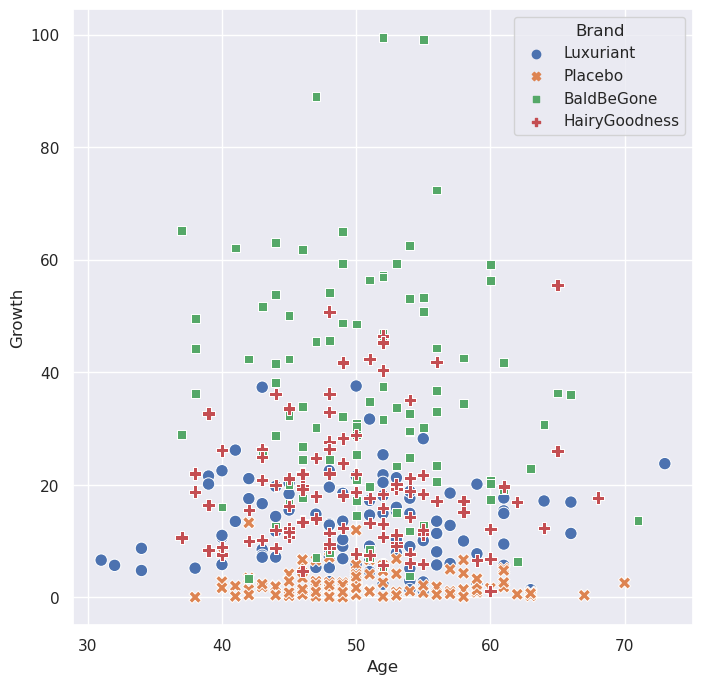

In [13]:
#| label: fig-scatterplot
#| fig-cap: "Scatter Plot of Age vs Hair Growth"

# Set the plot title
title = "Scatter Plot of Age vs Hair Growth (by Brand)"

# Resize the plot
sns.set(rc={"figure.figsize":(8, 8)}) 

# Create and render the plot
age_hair_scatterplot = sns.scatterplot(data=df2, 
                x="Age",
                y="Growth",
                style="Brand",
                hue="Brand",
                s=80)

A visual assessment in @fig-scatterplot does not show any particular pattern for age vs growth. However, the groupings show that Placebo had the lowest effect on growth at up to 20mm, and BaldBeGone had the highest from 20mm to above 60mm. Luxuriant performed averagely from 20mm to 40mm.

The mean ages were compared in @fig-box-age and showed similar quantiles (i.e., the 25$^{th}$ to 75$^{th}$ quantiles cover ages 45 to 55). @tbl-mean-age shows the mean age is around 50, and the 95% confidence intervals in @tbl-ci-age exhibit overlapping ranges (from  49 to 51). @fig-hist-age (in the Appendix) shows similar results.

The visualisations, similar mean ages and overlapping confidence intervals show that group ages are not statistically different. This makes it suitable to compare hair growth between groups.

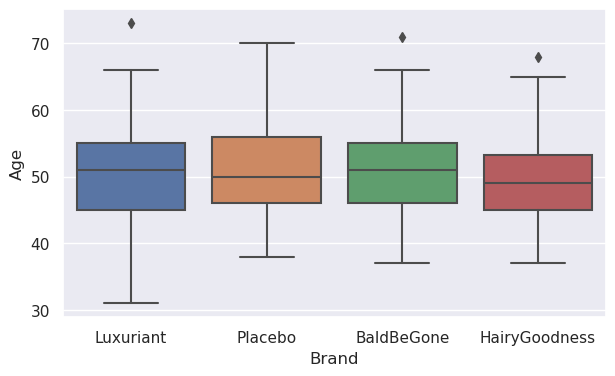

In [14]:
#| label: fig-box-age
#| fig-cap: "Box Plot of Participants' Age"

# Set the plot title
title = "Box Plot of Participants' Age by Brand"

# Resize this plot (and all plots moving forward)
sns.set(rc={"figure.figsize":(7, 4)}) 

# Create and render the plot
age_boxplot = sns.boxplot(data=df2,
                          x="Brand",
                          y="Age")

In [15]:
#| label: tbl-mean-age
#| tbl-cap: "Mean Age by Brand"

title = "Mean Age by Brand"

# Get the means for Age and Growth by group
tbl_means = df2.groupby(["Brand"])["Age",].mean().round(2).applymap(str).reindex(["Luxuriant", "Placebo", "BaldBeGone", "HairyGoodness"])

# tbl_means
tbl_means.style.set_caption(title)

,Age
Brand,
Luxuriant,50.29
Placebo,50.96
BaldBeGone,50.93
HairyGoodness,49.73


In [16]:
#| label: tbl-ci-age
#| tbl-cap: "95% Confidence Intervals for Age"

# Get the upper and lower confidence interval values for Age

# Luxuriant
age_l = list(sms.DescrStatsW(df["AgeLuxuriant"]).tconfint_mean())
age_l.insert(0, "Luxuriant")

# Placebo
age_p = list(sms.DescrStatsW(df["AgePlacebo"]).tconfint_mean())
age_p.insert(0, "Placebo")

# BaldBeGone
age_b = list(sms.DescrStatsW(df["AgeBaldBeGone"]).tconfint_mean())
age_b.insert(0, "BaldBeGone")

# HairyGoodness
age_h = list(sms.DescrStatsW(df["AgeHairyGoodness"]).tconfint_mean())
age_h.insert(0, "HairyGoodness")

# Concatenate the CIs per brand into one dataframe
title = "95% Confidence Intervals for Age"
ci_age_data = [age_l, age_p, age_b, age_h]
ci_age_df = pd.DataFrame(ci_age_data, columns = ["Names", "Lower Bound", "Upper Bound"]).round(2).applymap(str).set_index(["Names"])
ci_age_df.style.set_caption(title)

,Lower Bound,Upper Bound
Names,,
Luxuriant,48.78,51.8
Placebo,49.64,52.28
BaldBeGone,49.6,52.26
HairyGoodness,48.45,51.01


@tbl-mean-growth shows varying average hair growth by brand, with Placebo having the smallest growth at 2.49mm and BaldBeGone the highest at 36.15mm. The boxplot in @fig-box-growth also shows the 50$^{th}$ quantitles are different for all groups, with Luxuriant outperforming Placebo which has the lowest and narrowest growth, although BaldBeGone has the widest range. @fig-hist-growth histogram also shows different distributions.

The Confidence Intervals in @tbl-ci-growth show no overlaps between any group for hair growth. All these strongly suggest that there is a significant difference in growth among brands.

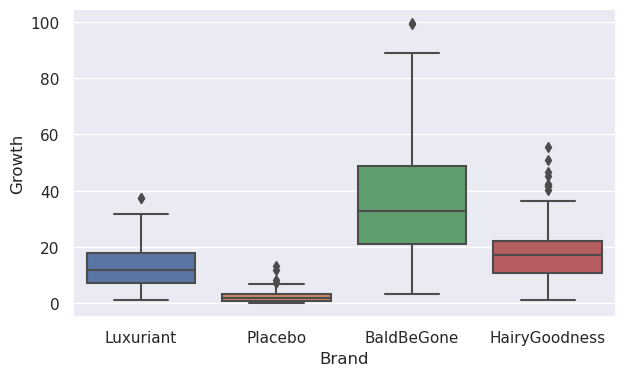

In [17]:
#| label: fig-box-growth
#| fig-cap: "Box Plot of Average Hair Growth"

# Box Plot of average growth per brand

# Set the plot title
title = "Box Plot of Average Hair Growth by Brand"

# Create and render the plot
avg_growth_boxplot = sns.boxplot(data=df2,
                                 x="Brand",
                                 y="Growth")

In [18]:
#| label: tbl-mean-growth
#| tbl-cap: "Means Hair Growth by Brand"

title = "Means of Hair Growth by Brand"
# Get the means for Age and Growth by group
tbl_means = df2.groupby(["Brand"])["Growth",].mean().round(2).applymap(str).reindex(["Luxuriant", "Placebo", "BaldBeGone", "HairyGoodness"])
tbl_means.style.set_caption(title)
#.set_table_styles(styles)

,Growth
Brand,
Luxuriant,13.0
Placebo,2.49
BaldBeGone,36.15
HairyGoodness,18.74


In [19]:
#| label: tbl-ci-growth
#| tbl-cap: "95% Confidence Intervals for Growth"

# Get the upper and lower confidence interval values for Growth

# Luxuriant
growth_l = list(sms.DescrStatsW(df["Luxuriant"]).tconfint_mean())
growth_l.insert(0, "Luxuriant")

# Placebo
growth_p = list(sms.DescrStatsW(df["Placebo"]).tconfint_mean())
growth_p.insert(0, "Placebo")

# BaldBeGone
growth_b = list(sms.DescrStatsW(df["BaldBeGone"]).tconfint_mean())
growth_b.insert(0, "BaldBeGone")

# HairyGoodness
growth_h = list(sms.DescrStatsW(df["HairyGoodness"]).tconfint_mean())
growth_h.insert(0, "HairyGoodness")

# Concatenate all the CIs into one dataframe
title = "Table 5: 95% Confidence Intervals for Growth"
ci_growth_data = [growth_l, growth_p, growth_b, growth_h]
ci_growth_df = pd.DataFrame(ci_growth_data, columns = ["Names", "Lower Bound", "Upper Bound"]).set_index(["Names"]).round(2).applymap(str)
ci_growth_df.style.set_caption(title)

,Lower Bound,Upper Bound
Names,,
Luxuriant,11.51,14.49
Placebo,2.01,2.96
BaldBeGone,32.23,40.07
HairyGoodness,16.55,20.93


To verify the null hypothesis ($H_{0}$: There is no difference in growth between groups), @tbl-anova shows that growth has a significant p-value of almost zero (unlike age which is not significant at the 0.1 level).

For the other null hypothesis ($H_{0}$: There is no difference in growth between Luxuriant and Placebo), @tbl-ttest also shows a significant p-value of close to zero. 

In [20]:
# ANOVA test on ages for all brands

# Perform ANOVA test on age columns
anova_age = f_oneway(df["AgeLuxuriant"], df["AgePlacebo"], df["AgeBaldBeGone"], df["AgeHairyGoodness"])

# Convert into a list object
anova_age = list(anova_age)

# Add "Age" label
anova_age.insert(0, "Age")

In [21]:
# ANOVA test on hair growth for all brands

# Perform ANOVA test on growth columns
anova_growth = f_oneway(df["Luxuriant"], df["Placebo"], df["BaldBeGone"], df["HairyGoodness"])

# Convert into a list object
anova_growth = list(anova_growth)

# Add "Age" label
anova_growth.insert(0, "Growth")

In [22]:
#| label: tbl-anova
#| tbl-cap: "ANOVA Results for All Brands"

# Set the table title
title = "ANOVA Results for Age and Growth \nfor All Brands"

# Concatenate ANOVA age and growth data
anova_data = [anova_age, anova_growth]

# Convert to pandas dataframe, set the table column names and display the table
anova_df = pd.DataFrame(anova_data, columns = ["Test Variable", "Statistic", "P-Value"]).set_index(["Test Variable"])
anova_df.style.set_caption(title)

,Statistic,P-Value
Test Variable,,
Age,0.730105,0.534507
Growth,138.297504,0.000000


In [23]:
# T-test on ages between Luxuriant and Placebo

# Perform the t-test on age columns
ttest_age = ttest_ind(df["AgeLuxuriant"], df["AgePlacebo"])

# Convert to a list
ttest_age = list(ttest_age)

# Add a label
ttest_age.insert(0, "Age")

In [24]:
# T-test on hair growth between Luxuriant and Placebo

# Perform the t-test on growth columns
ttest_growth = ttest_ind(df["Luxuriant"], df["Placebo"])

# Convert to a list
ttest_growth = list(ttest_growth)

# Add a label
ttest_growth.insert(0, "Growth")

In [25]:
#| label: tbl-ttest
#| tbl-cap: "T-Test Between Luxuriant and Placebo"

# Set the table title
title = "T-Test Between Luxiriant and Placebo"

# Concatenate the t-test for age and growth
ttest_data = [ttest_age, ttest_growth]

# Convert to pandas dataframe, set the table column names and display the table
ttest_df = pd.DataFrame(ttest_data, columns = ["Test Variable", "Statistic", "P-Value"]).set_index(["Test Variable"])
ttest_df.style.set_caption(title)

,Statistic,P-Value
Test Variable,,
Age,-0.662467,0.508442
Growth,13.307183,0.000000


These results show that both null hypotheses can be rejected. Therefore, there is a significant difference in hair growth between groups, and between Luxuriant and Placebo.

In [26]:
# Create an OLS model with growth as response variable, and age & brand as the predictors

# Change "Brand" column to "category" type
df2["Brand"] = pd.Series(df2["Brand"], dtype="category")

# Describe the model
sm_lm = smf.ols(formula="Growth ~ Age + Brand", data=df2)

# fit the model
sm_lm_fit = sm_lm.fit()

# Get the summary
sm_lm_summary = sm_lm_fit.summary2()

# See appendix section for the summary table

The OLS linear model can be described as:

$$
\hat{Growth} = 39.89 + Brand -0.07Age
$${#eq-ols-model}

The resulting p-value for age (@tbl-ols) is non-significant. This implies that age is not a determining factor in hair growth.

In [27]:
# Conduct Shapiro–Wilk test
shapiro_result = shapiro(sm_lm_fit.resid)
#shapiro_pval = shapiro_result[1]

# Uncomment to view the shapiro p-value
# print(shapiro_result)

Moreover, the model's adjusted R-squared value is only 0.5. There are further evidence of non-normality; the residuals plot (@fig-hist-residuals) looks non-normally distributed, and the QQ Plot (@fig-qqplot) shows skewed data. The Shapiro-Wilk test also yields W=0.91 and p-value=9.93e-15, confirming non-normal distribution (Navarro, 2015).

Although the model is underpredicting, it can still be used to illustrate growth by brand. @tbl-predictions shows that Placebo has the least growth while BaldBeGone has the highest, with Luxuriant in the middle.

In [28]:
# Predict hair growth when age=50

# Create the dataframe
dfPred = pd.DataFrame(np.zeros((4,2)), columns=["Brand", "Age"])

# add the data
dfPred.iloc[0:] = ["Luxuriant", 50]
dfPred.iloc[1:] = ["Placebo", 50]
dfPred.iloc[2:] = ["BaldBeGone", 50]
dfPred.iloc[3:] = ["HairyGoodness", 50]

#predict the growth
predictions = sm_lm_fit.predict(dfPred)

In [29]:
#| label: tbl-predictions
#| tbl-cap: "Predicted Growth For Age=50"

# Display the dataframe for predicted growth

title = "Predicted Growth For Age=50"

# Convert the prediction results into a pandas dataframe
PredResults = pd.DataFrame({"Brand": ["Luxuriant", "Placebo", "BaldBeGone", "HairyGoodness"],
        "Predicted Growth": predictions.round(2).apply(str)})
PredResults.style.set_caption(title)

,Brand,Predicted Growth
0,Luxuriant,13.02
1,Placebo,2.56
2,BaldBeGone,36.22
3,HairyGoodness,18.72


# Conclusion and Recommendation

The analysis shows that Luxuriant has a significant growth effect over the Placebo by 10.51mm (13.0mm for Luxuriant versus 2.49mm for Placebo). However, Luxuriant is less effective than BaldBeGone and HairyGoodness which average 36.15mm and 18.74mm respectively. Age was not found to be a relevant effect.

While Luxuriant's performance is not as large as the existing brands, it still has a significant effect over the Placebo. It can therefore be released with the tested claim that it improves hair growth regardless of age.

To improve clinical trials, there should be separate test phases (Hulley et al., 2013); one phase for testing against the Placebo (phase 2), another to test against existing hair treatments (phase 3), and an optional study after Luxuriant's introduction to the public (phase 4).

# References
Heumann, C., Schomaker, M., &amp; Shalabh. (2022). *Introduction to statistics and Data Analysis: With exercises, solutions and applications in R* (Second Edition). Springer International. 

Hulley, S. B., Cummings, S. R., Browner, W. B., Grady, D. G., &amp; Newman, T. B. (2013). *Designing Clinical Research* (Fourth edition). Lippincott, Williams &amp; Wilkins. 

McKinney, W. (2022). *Python for Data Analysis. Python for Data Analysis*, Third Edition. https://wesmckinney.com/book/ 

Navarro, D. (2015). *Learning statistics with R: A tutorial for psychology students and other beginners*. Open Textbook Library. https://open.umn.edu/opentextbooks/textbooks/559 

*Seaborn User Guide and Tutorial*. User guide and tutorial - seaborn 0.13.0 documentation. (2023). https://seaborn.pydata.org/tutorial.html 

*SciPy Documentation*. SciPy documentation - SciPy v1.11.3 Manual. (2023, September 27). https://docs.scipy.org/doc/scipy/ 


# Appendix

In [30]:
# The following raw code will resize the output table to fit the width of the PDF

In [31]:
#| label: tbl-converted-figures
#| tbl-cap: "Head of Dataframe with Converted Figures"

# Set the table title
title = "Head of Data Frame with Converted Growth and Age Figures"

df_head.style.set_caption(title)

,Luxuriant,Placebo,BaldBeGone,HairyGoodness,AgeLuxuriant,AgePlacebo,AgeBaldBeGone,AgeHairyGoodness
0,20.122736,2.047563,7.125638,13.230100,59,44,51,51
1,15.377107,0.957729,57.176273,10.711428,61,53,52,52
2,17.638841,2.467823,36.108605,46.497552,54,48,66,52
3,1.379751,5.521011,17.651599,21.165904,63,46,46,54
4,37.558535,4.992816,19.100094,7.640771,50,57,61,40


In [32]:
# The following chunk reverts the font changes from the table

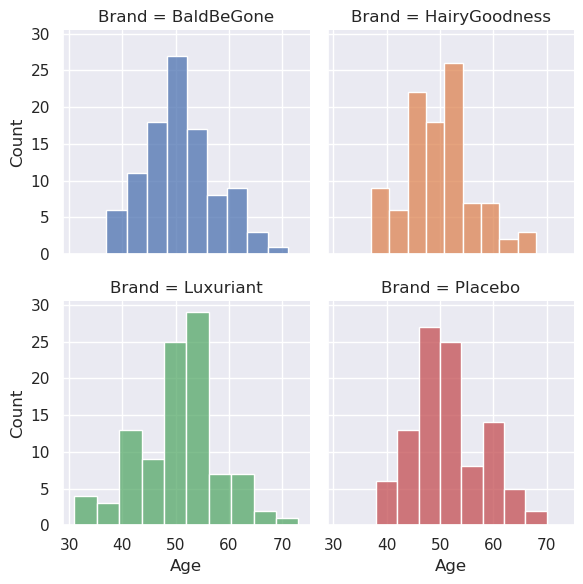

In [33]:
#| label: fig-hist-age
#| fig-cap: "Histograms of participants' age by brand, showing fairly similar distributions"

# Set the plot title
title = "Histograms of Participants' Age by Brand"

# Create the plots
g = sns.FacetGrid(df2,
                  col = "Brand",
                  hue="Brand",
                  col_wrap=2)

# Render the plots
growth_histograms = g.map_dataframe(sns.histplot, 
                                    x="Age")

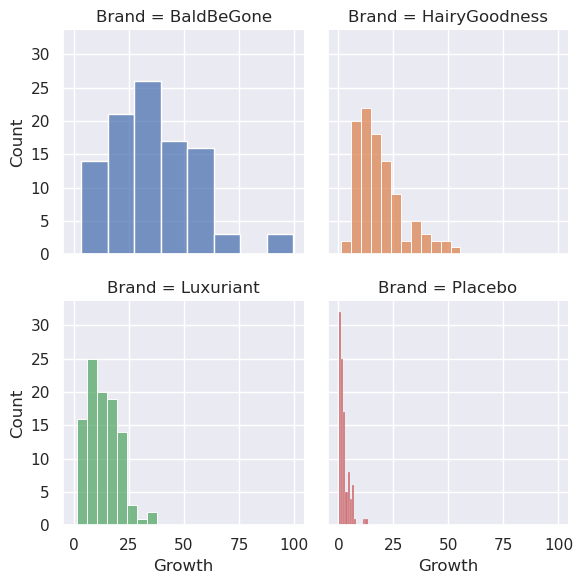

In [34]:
#| label: fig-hist-growth
#| fig-cap: "Histograms of hair growth by brand, showing signficantly varying distributions"

# Set the plot title
title = "Histograms of Participants' Growth by Brand"

# Create the plots
g = sns.FacetGrid(df2,
                  col = "Brand",
                  hue="Brand",
                  col_wrap=2)

# Render the plots
growth_histograms = g.map_dataframe(sns.histplot, 
                                    x="Growth")

In [35]:
#| label: tbl-ols
#| tbl-cap: "OLS Summary Table showing the Adj R-squared value and Age p-value"

sm_lm_summary

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                  OLS                Adj. R-squared:       0.508    
Dependent Variable:     Growth             AIC:                  3126.7791
Date:                   2023-11-17 07:57   BIC:                  3146.7365
No. Observations:       400                Log-Likelihood:       -1558.4  
Df Model:               4                  F-statistic:          103.8    
Df Residuals:           395                Prob (F-statistic):   2.41e-60 
R-squared:              0.513              Scale:                143.55   
--------------------------------------------------------------------------
                        Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
--------------------------------------------------------------------------
Intercept               39.8905   4.6262   8.6228 0.0000  30.7956  48.9855
Brand[T.HairyGoodness] -17.5001   1.6976 -10.3085 0.0000 -20.8377 -14.1626
Brand[T.Luxuriant]     -23.1996   1.6953 -13.6846 0.0000 -26.5326 -19.8667
Brand[T.Placebo]       -33.6649   1.6944 -19.8686 0.0000 -36.9960 -30.3337
Age                     -0.0734   0.0877  -0.8366 0.4033  -0.2459   0.0991
--------------------------------------------------------------------------
Omnibus:                 111.514         Durbin-Watson:            1.977  
Prob(Omnibus):           0.000           Jarque-Bera (JB):         495.130
Skew:                    1.137           Prob(JB):                 0.000  
Kurtosis:                7.953           Condition No.:            398    
==========================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
"""

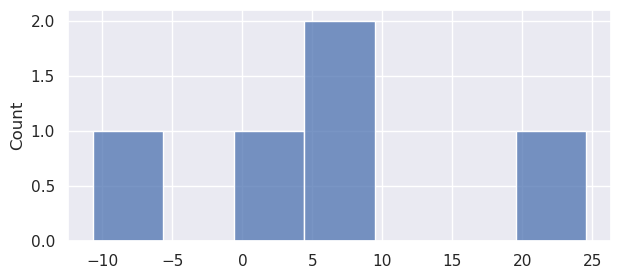

In [36]:
#| label: fig-hist-residuals
#| fig-cap: "Histograms of OLS model residuals showing non-normal distribution"

# Resize the plots
sns.set(rc={"figure.figsize":(7, 3)}) 

# Create and render the plot
resplot = sns.histplot(sm_lm_fit.resid.head())

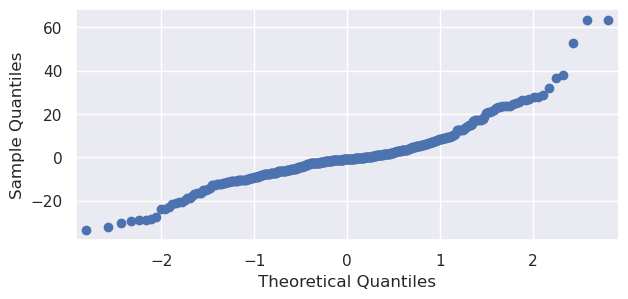

In [37]:
#| label: fig-qqplot
#| fig-cap: "QQ Plot showing slightly downward skewed data"

# QQ Plot
# Set the plot title
title = "Figure 7: QQ Plot"

# Create and render the plot
qq_plot = qqplot(sm_lm_fit.resid)

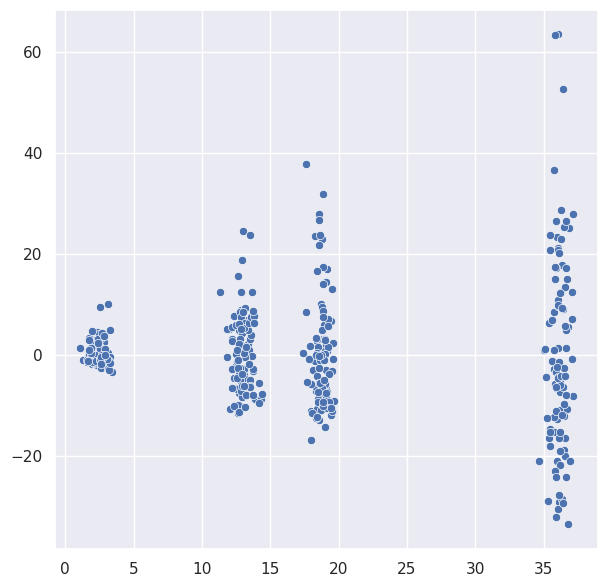

In [38]:
#| label: fig-res-vs-fitted
#| fig-cap: "Residuals vs Fitted Values showing dense points in the lower residual values"

# Residuals vs Fitted Values Plot

# Resize this plot (and all plots moving forward)
sns.set(rc={"figure.figsize":(7, 7)}) 

# Set the plot title
title = "Residuals vs Fitted Values"
res_vs_fit_plot = sns.scatterplot(x=sm_lm_fit.fittedvalues,
                                y=sm_lm_fit.resid)

In [39]:
# The following Tukey's HSD was not included in the final report

#| label: tukey-hsd-age
#| fig-cap: "Tukey's HSD for Age shows shows non-significant p-values, and confirms age is the same for all groups."

# from scipy.stats import tukey_hsd
# age_tukey = tukey_hsd(df["AgeLuxuriant"], df["AgePlacebo"], df["AgeBaldBeGone"], df["AgeHairyGoodness"])
# print(age_tukey)

In [40]:
#| label: tukey-hsd-growth
#| fig-cap: "Tukey's HSD for Growth shows shows significant p-values, confirming growth is different between all groups."

# growth_tukey = tukey_hsd (df["Luxuriant"], df["Placebo"], df["BaldBeGone"], df["HairyGoodness"])
# print(growth_tukey)